# Data Cleaning and Preprocessing

Data cleaning and preprocessing are essential steps before applying machine learning models.
This process ensures that data is structured, error-free, and transformed into a format
suitable for analysis.

This notebook will cover the basis and simple techniques of:
- Handling missing values
- Detecting and treating outliers
- Encoding categorical variables
- Scaling and normalising numerical features
- Feature transformations

We will use datasets previously explored in the EDA notebooks to maintain consistency.

## Index

1. [Missing Values](#1-missing-values)
2. [Outlier detection](#2-outlier-detection)
3. [Encoding Categorical Variables](#3-encoding-categorical-values)
4. [Scale and Normalisation](#4-scaling-and-normalizing-numerical-values)
5. [Feature Transformations](#5-feature-transformations)
6. [Extra Resources](#6-extra-resources)

**Libraries used:**

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder

# Load Datasets from Previous Notebooks
df_titanic = sns.load_dataset("titanic")  # Categorical-heavy dataset
df_diamonds = sns.load_dataset("diamonds")  # Numerical-heavy dataset

df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## 1. Missing values

Missing data can introduce bias and reduce model accuracy. They may appear as `NaN`, `None`, blank cells in spreadsheets, `?` or some placeholder values like `-1` or `999`, for example. Understanding the nature of missing data is crucial for choosing the right handling strategy. It can be defined as 3 different types:
    
1. **Missing Completely at Random (MCAR):** The missingness is unrelated to any other variable or the missing value itself. A sensor randomly failing to record data is an example;
2. **Missing at Random (MAR):** The missingness is related to other observed variables but not the missing value itself. For example, a survey where younger respondents are less likely to disclose their income;
3. **Missing Not at Random (MNAR):** The missingness is related to the missing value itself. For example, people with higher incomes are less likely to disclose their income in a survey.

After realizing that there is missing data, there are some different strategies on how to handle it:
    
1. **Removing Missing Values:** Either by removing the `rows` with missing values (recomended for rows where the target value is missing), or `columns` (if there are so many values missing that not having the column is beneficial). While this procedure is simple and quick, it comes with the loss of data, which may reduce the dataset's size and affect analysis;
2. **Imputation:** Imputation involves filling in missing values with estimated or calculated values. Common methods include:
    1. **Mean/Median/Mode Imputation:** Replace missing values with the mean (for numerical data), median (for skewed data), or mode (for categorical data);
    2. **Forward Fill or Backward Fill:** Use previous or next values to fill missing data (common in time series);
    3. **Interpolation:** Estimate missing values using interpolation methods (e.g., linear, polynomial);
    4. **K-Nearest Neighbors (KNN) Imputation:** Use the values of the nearest neighbors to impute missing data;
   
Below is an example of missing data detection and handling on an example-dataset:

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64
survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    2
alive          0
alone          0
Has_deck       0
dtype: int64


C:\Users\afons\AppData\Local\Temp\ipykernel_17292\2663770147.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_titanic['age'].fillna(df_titanic['age'].median(), inplace=True)
C:\Users\afons\AppData\Local\Temp\ipykernel_17292\2663770147.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

<Axes: >

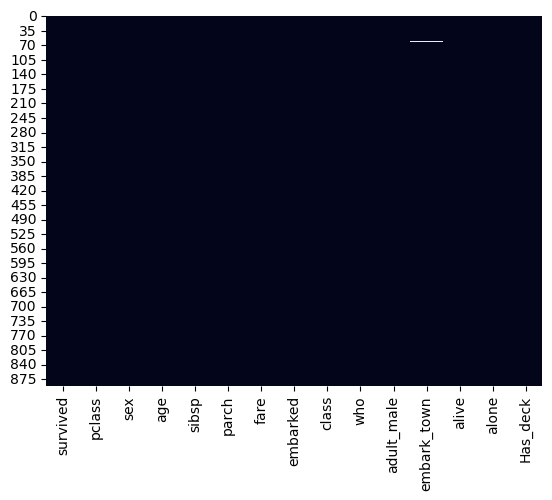

In [11]:
# Check for missing values
print(df_titanic.isnull().sum())
sns.heatmap(df_titanic.isnull(), cbar=False)

# Handle missing 'Age' values (impute with median)
df_titanic['age'].fillna(df_titanic['age'].median(), inplace=True)

# Handle missing 'Embarked' values (impute with mode)
df_titanic['embarked'].fillna(df_titanic['embarked'].mode()[0], inplace=True)

# Handle 'Cabin' column (create a new feature and drop the original)
df_titanic['Has_deck'] = df_titanic['deck'].notnull().astype(int)
df_titanic.drop('deck', axis=1, inplace=True)

# Verify that missing values are handled
print(df_titanic.isnull().sum())
sns.heatmap(df_titanic.isnull(), cbar=False)


## 2. Outlier detection

Outliers can skew statistical analyses and models. Here are some common techniques to handle them:
- **Z-score method**: Removing values beyond 3 standard deviations.
- **Interquartile Range (IQR)**: Identifying extreme values.
- **Winsorization**: Capping extreme values.

In [8]:
from scipy.stats import zscore

Z = zscore(df_diamonds["price"])
outliers = df_diamonds[(Z < -3) | (Z > 3)]
print(f"Number of Outliers in Price, using Z-Score: {outliers.shape[0]}")

# Detecting outliers using IQR
Q1 = df_diamonds['price'].quantile(0.25)
Q3 = df_diamonds['price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_diamonds[(df_diamonds['price'] < (Q1 - 1.5 * IQR)) | (df_diamonds['price'] > (Q3 + 1.5 * IQR))]
print(f"Number of Outliers in Price, using IQR: {outliers.shape[0]}")

Number of Outliers in Price, using Z-Score: 1206
Number of Outliers in Price, using IQR: 3540


## 3. Encoding categorical values

Machine learning models require numerical inputs. As such, categorical data needs to be converted to numerical representations. This process is called encoding. Some of the encoding methods include:

- **Label Encoding**: Assigning numerical values to categories.
- **One-Hot Encoding**: Creating binary columns for each category.
- **Target Encoding**: Replacing categories with mean target value.

In [4]:
# Label Encoding example
le = LabelEncoder()
df_titanic['sex_encoded'] = le.fit_transform(df_titanic['sex'])
print(df_titanic[['sex', 'sex_encoded']].head())

# One-Hot Encoding example
df_titanic_encoded = pd.get_dummies(df_titanic, columns=['embark_town'], drop_first=True)
print(df_titanic_encoded.head())

      sex  sex_encoded
0    male            1
1  female            0
2  female            0
3  female            0
4    male            1
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck alive  alone  sex_encoded  embark_town_Queenstown  \
0    man        True  NaN    no  False            1                   False   
1  woman       False    C   yes  False            0                   False   
2  woman       False  NaN   yes   True            0                   False   
3  woman       False    C   yes  False            0                   False   
4    man  

## 4. Scaling and Normalizing numerical values

Scaling ensures numerical features have comparable ranges. Models can be more susceptible to change in its learning phase if numerical features have a wide range. There are some ways to ensure this process, such as:

- **Standard Scaling (Z-score Normalization)**: Centering at 0, scaling by standard deviation.
- **Min-Max Scaling**: Transforming values to range [0,1].
- **Robust Scaling**: Scaling using median and IQR, useful for outliers.

In [5]:
# Standard Scaling example
scaler = StandardScaler()
df_diamonds['price_scaled'] = scaler.fit_transform(df_diamonds[['price']])
print(df_diamonds[['price', 'price_scaled']].head())

   price  price_scaled
0    326     -0.904095
1    326     -0.904095
2    327     -0.903844
3    334     -0.902090
4    335     -0.901839


## 5. Feature transformations

Feature transformations can improve model performance by making distributions more normalized.
- **Log Transformation**: Reducing right skewness.
- **Square Root Transformation**: Reducing impact of large values.
- **Polynomial Features**: Capturing non-linear relationships.

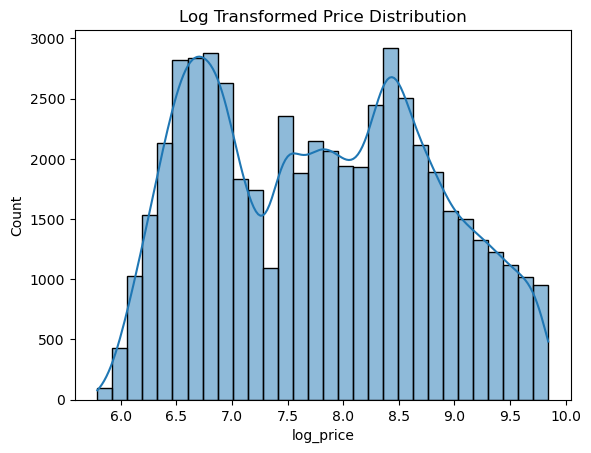

In [6]:
# Log Transformation Example
df_diamonds['log_price'] = np.log1p(df_diamonds['price'])
sns.histplot(df_diamonds['log_price'], bins=30, kde=True)
plt.title("Log Transformed Price Distribution")
plt.show()


## 6. Extra Resources

For further context and information:

- [Encord Article](https://encord.com/blog/data-cleaning-data-preprocessing/)
- [Scikit-learn: Preprocessing Data](https://scikit-learn.org/stable/modules/preprocessing.html)